<a href="https://colab.research.google.com/github/fabiano182/AMC/blob/main/AMC_MIMO_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AUTOMATIC MODULATION CLASSIFICATION
Autor: Fabiano Rocha De Oliveira

## Configuração do PC do Google Colab

In [ ]:
!apt install neofetch && neofetch

Reading package lists... Done
Building dependency tree       
Reading state information... Done
neofetch is already the newest version (3.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
            .-/+oossssoo+/-. 
        `:+ssssssssssssssssss+:` 
      -+ssssssssssssssssssyyssss+- 
    .ossssssssssssssssssdMMMNysssso. 
   /ssssssssssshdmmNNmmyNMMMMhssssss/ 
  +ssssssssshmydMMMMMMMNddddyssssssss+ 
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/ 
.ssssssssdMMMNhsssssssssshNMMMdssssssss. 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+ 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+ 
.ssssssssdMMMNhsssssssssshNMMMdssssssss. 
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/ 
  +sssssssssdmydMMMMMMMMddddyssssssss+ 
   /ssssssssssshdmNNNNmyNMMMMhssssss/ 
    .ossssssssssssssssssdMMMNysssso. 
      -+sssssssssssssssssyyyssss+- 
        `:+ssssssssssssssssss+:` 
            .-/+oossssoo+/-. 
root@35addf25b61b 
---

In [ ]:
!python -V

Python 3.7.12


In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt


2.6.0


## DATASET


### Modelo do Sinal

In [ ]:
# def psk_mod(M ,L):
#   m = np.arange(0,M)
#   if (M==2):
#     constellation = np.cos(m/M*2*np.pi)
#   elif (M==4):
#     constellation = np.exp(1j*np.pi/4)*(np.cos(m/M*2*np.pi) + 1j*np.sin(m/M*2*np.pi))
#   else :
#     constellation = np.cos(m/M*2*np.pi) + 1j*np.sin(m/M*2*np.pi)
#   in_syms = np.random.randint(low=0, high = M, size=L)
#   s = constellation[in_syms]
#   return s

# s = (1/np.sqrt(2))*psk_mod(8,128)
# fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
# ax1.plot(np.real(s),np.imag(s),'*')
# ax2.plot(s.real)
# ax2.plot(s.imag)
# plt.show()

# print('\n\n')

# def qam_mod(M,L):
#   n = np.arange(0,M)
#   a = np.asarray([x^(x>>1) for x in n])
#   D = np.sqrt(M).astype(int)
#   a = np.reshape(a,(D,D))

        
#   nGray=np.reshape(a,(M)) 

#   (x,y)=np.divmod(nGray,D) 
#   Ax=2*x+1-D
#   Ay=2*y+1-D 

#   constellation = Ax + 1j*Ay

#   in_syms = np.random.randint(low=0, high = M, size=L)
#   s = constellation[in_syms]
#   return s

# c = (1/np.sqrt(170))*qam_mod(64,128)
# fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
# ax1.plot(np.real(c),np.imag(c),'*')
# ax2.plot(c.real)
# ax2.plot(c.imag)
# plt.show()

In [ ]:
!pip install ModulationPy==0.1.8

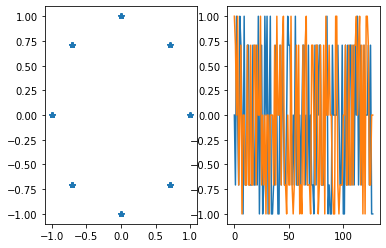

In [ ]:
from ModulationPy import PSKModem, QAMModem

def psk_mod(M, L):
  modem = PSKModem(M, gray_map=True, bin_input=False)

  if M==4: 
    modem = PSKModem(M, phi=np.pi/4, gray_map=True, bin_input=False)
  
  input = np.random.randint(low=0, high=M, size=L)
  x = modem.modulate(input)
  
  return x

def qam_mod(M, L):
  modem = QAMModem(M, gray_map=True, bin_input=False)
  input = np.random.randint(low=0, high=M, size=L)
  x = modem.modulate(input)
  
  return x

s = psk_mod(8,128)
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(np.real(s),np.imag(s),'*')
ax2.plot(s.real)
ax2.plot(s.imag)
plt.show()

### Canal Rayleigh Estático

In [ ]:
def rayChan(nTx, nRx):
  h = (1/np.sqrt(2))*(np.random.randn(nTx,nRx) + 1j*np.random.randn(nTx,nRx))
  #h = np.ones([nTx,nRx])
  return h

### Canal AWGN

In [ ]:
def awgn(snr, nRx, L):
  EbNo = snr
  var = np.sqrt(1/(10**(EbNo/10))) 
  w = (np.random.normal(0,var,(1,nRx,L)) + 1j*np.random.normal(0,var,(1,nRx,L)))
  return w

### Modelo do sistema


In [ ]:
def mimo(x, nTx, nRx, snr, L):
  x = np.tile(x,(nTx,1))
  H = rayChan(nTx,nRx)
  w = awgn(snr, nRx, L)

  # print(H.shape)
  # print(x.shape)
  # print(w.shape)
  y = np.sum(np.dot(H.T,x)+w, axis=1)/(nTx*nRx)
  # if nRx >= nTx:
  #   y = np.sum((np.dot(H.T,x) + w)/np.sqrt((nTx*nRx)), axis=1)
  # else:
  #   y = np.sum((H*x + w)/np.sqrt((nTx*nRx)), axis=1)

  #return y
  return np.reshape(np.array([[y.real],[y.imag]]),[1,2,L])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


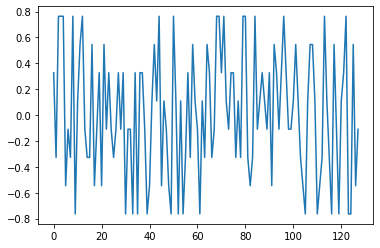

0.06787166328560243
8.687572900557111


In [ ]:
y = (1/np.sqrt(2))*qam_mod(64,128)/np.sqrt(42)

plt.plot(y)
plt.show()

p = np.abs(np.sum(y*y)/y.size)
print(p)

e = p*y.size
print(e)

### Dataset completo


[ 0. 20.]


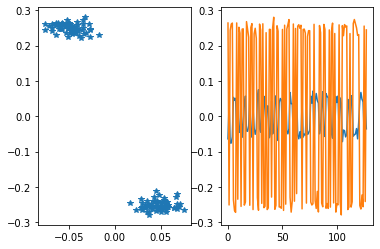

[ 1. 20.]


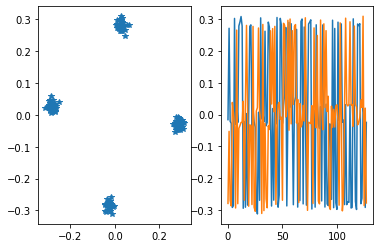

[ 2. 20.]


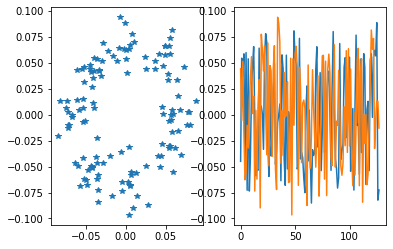

[ 3. 20.]


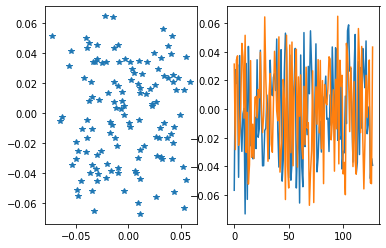

(87500, 2, 128)
(87500,)
(87500,)


In [ ]:
nTx = 4; nRx = 4; L = 128
snrs = list(range(-10,25,5))
ntest = 2500
t = ntest*len(snrs)
data_bpsk = np.zeros([t,2,L])
data_qpsk = np.zeros([t,2,L])
data_16qam = np.zeros([t,2,L])
data_8psk = np.zeros([t,2,L])
data_64qam = np.zeros([t,2,L])

lbl_bpsk = np.zeros([t,2])
lbl_qpsk = np.zeros([t,2])
lbl_8psk = np.zeros([t,2])
lbl_16qam = np.zeros([t,2])
lbl_64qam = np.zeros([t,2])

for i,snr in enumerate(snrs):
  for j in range(ntest):
    data_bpsk[i*ntest+j,:,:] = mimo(psk_mod(2,L), nTx, nRx ,snr, L)
    lbl_bpsk[i*ntest+j,:] = [0, snr]
  
  for j in range(ntest):
    data_qpsk[i*ntest+j,:,:] = mimo((1/np.sqrt(2))*psk_mod(4,L), nTx, nRx ,snr, L)
    lbl_qpsk[i*ntest+j,:] = [1, snr]

  for j in range(ntest):
    data_8psk[i*ntest+j,:,:] = mimo((1/np.sqrt(2))*psk_mod(8,L), nTx, nRx ,snr, L)
    lbl_8psk[i*ntest+j,:] = [2, snr]
  
  for j in range(ntest):
    data_16qam[i*ntest+j,:,:] = mimo((1/np.sqrt(10))*qam_mod(16,L), nTx, nRx ,snr, L)
    lbl_16qam[i*ntest+j,:] = [3, snr]
  
  for j in range(ntest):
    data_64qam[i*ntest+j,:,:] = mimo((1/np.sqrt(42))*qam_mod(64,L), nTx, nRx ,snr, L)
    lbl_64qam[i*ntest+j,:] = [4, snr]

print(lbl_bpsk[-1,:])
sI = data_bpsk[-1,0,:]; sQ = data_bpsk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_qpsk[-1,:])
sI = data_qpsk[-1,0,:]; sQ = data_qpsk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_8psk[-1,:])
sI = data_8psk[-1,0,:]; sQ = data_8psk[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)
plt.show()

print(lbl_16qam[-1,:])
sI = data_16qam[-1,0,:]; sQ = data_16qam[-1,1,:]
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
ax1.plot(sI, sQ,'*')
ax2.plot(sI)
ax2.plot(sQ)

# print(lbl_64qam[-1,:])
# sI = data_64qam[-1,0,:]; sQ = data_64qam[-1,1,:]
# fig, (ax1, ax2) = plt.subplots(nrows=1,ncols = 2)
# ax1.plot(sI, sQ,'*')
# ax2.plot(sI)
# ax2.plot(sQ)

plt.show()

data = np.vstack((data_bpsk, data_qpsk, data_8psk, data_16qam, data_64qam))
label = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,0].astype(int)
snrs = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,1].astype(int)
print(data.shape)
print(label.shape)
print(snrs.shape)

## REDE NEURAL
Leitura do Dataset

One Hot Encode

In [ ]:
def one_hot_encode(x, n_classes):
  return np.eye(n_classes)[x]

n_classes = 5
lbl_onehot = one_hot_encode(label.T, n_classes)

Xt = data
Yt = lbl_onehot

print(Xt.shape)
print(Yt.shape)

(87500, 2, 128)
(87500, 5)


Shuffle(Embaralhamento) e Split(Separação Treino-Validação)

In [ ]:
idx = list(range(lbl_onehot.shape[0]))
np.random.shuffle(idx)

data = data[idx,:,:]
lbl_onehot = lbl_onehot[idx,:]
snrs = snrs[idx]

split = 0.75 #70% Treino 30% Validação
total = data.shape[0] #30k amostras
sp = int(split*total)

X_test = data[:sp,:,:]
Y_test = lbl_onehot[0:sp,:]

X_val = data[-(total-sp):,:,:]
Y_val = lbl_onehot[-(total-sp):,:]

print(X_test.shape, X_val.shape)
print(Y_test.shape,Y_val.shape)
#print(snrs.shape)

(65625, 2, 128) (21875, 2, 128)
(65625, 5) (21875, 5)


In [ ]:
import keras
from keras.layers import *
from keras.models import Model
from keras.activations import *
from keras.callbacks import ModelCheckpoint, EarlyStopping

def cnn2():
  dr = 0.25

  input = Input((2, L, 1))
  x = ZeroPadding2D((0,2))(input)                               
  x = Conv2D(256, (2, 3))(x)
  x = ReLU()(x)                                   
  x = Dropout(dr)(x)

  x = ZeroPadding2D((0,2))(x) 
  x = Conv2D(64, (1, 3))(x)   
  x = ReLU()(x)
  x = Dropout(dr)(x)

  x = Flatten()(x)
  x = Dense(128)(x)
  x = ReLU()(x)
  x = Dropout(dr)(x)


  output = Dense(n_classes, activation='softmax')(x)      #Camada de saida
  model = Model(inputs=input, outputs=output)
  #model.summary()
  return model

In [ ]:
%%time
model = cnn2()
opt = tf.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

history = model.fit(X_test,Y_test,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val,Y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', verbose=1, patience=20)])

Epoch 1/100
513/513 [==============================] - 10s 18ms/step - loss: 1.4443 - categorical_accuracy: 0.3158 - val_loss: 1.3131 - val_categorical_accuracy: 0.3738
Epoch 2/100
513/513 [==============================] - 9s 17ms/step - loss: 1.2889 - categorical_accuracy: 0.3856 - val_loss: 1.2478 - val_categorical_accuracy: 0.3862
Epoch 3/100
513/513 [==============================] - 9s 17ms/step - loss: 1.1668 - categorical_accuracy: 0.4344 - val_loss: 1.1098 - val_categorical_accuracy: 0.4479
Epoch 4/100
513/513 [==============================] - 9s 17ms/step - loss: 1.1139 - categorical_accuracy: 0.4565 - val_loss: 1.1060 - val_categorical_accuracy: 0.4543
Epoch 5/100
513/513 [==============================] - 9s 17ms/step - loss: 1.0823 - categorical_accuracy: 0.4792 - val_loss: 1.0915 - val_categorical_accuracy: 0.4665
Epoch 6/100
513/513 [==============================] - 9s 17ms/step - loss: 1.0533 - categorical_accuracy: 0.5033 - val_loss: 1.0841 - val_categorical_accuracy

## Análise do treinamento

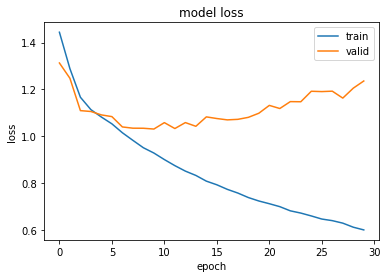

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

Novos dados de teste da reda


In [ ]:
#nTx = 2; nRx = 1; L = 128
snrs = list(range(-20, 25,5))
ntest = 500
t = ntest*len(snrs)
data_bpsk = np.zeros([t,2,L])
data_qpsk = np.zeros([t,2,L])
data_8psk = np.zeros([t,2,L])
data_16qam = np.zeros([t,2,L])
data_64qam = np.zeros([t,2,L])

lbl_bpsk = np.zeros([t,2])
lbl_qpsk = np.zeros([t,2])
lbl_8psk = np.zeros([t,2])
lbl_16qam = np.zeros([t,2])
lbl_64qam = np.zeros([t,2])

for i,snr in enumerate(snrs):
  for j in range(ntest):
    data_bpsk[i*ntest+j,:,:] = mimo(psk_mod(2,L), nTx, nRx ,snr, L)
    lbl_bpsk[i*ntest+j,:] = [0, snr]
  
  for j in range(ntest):
    data_qpsk[i*ntest+j,:,:] = mimo((1/np.sqrt(2))*psk_mod(4,L), nTx, nRx ,snr, L)
    lbl_qpsk[i*ntest+j,:] = [1, snr]

  for j in range(ntest):
    data_8psk[i*ntest+j,:,:] = mimo((1/np.sqrt(2))*psk_mod(8,L), nTx, nRx ,snr, L)
    lbl_8psk[i*ntest+j,:] = [2, snr]
  
  for j in range(ntest):
    data_16qam[i*ntest+j,:,:] = mimo((1/np.sqrt(10))*qam_mod(16,L), nTx, nRx ,snr, L)
    lbl_16qam[i*ntest+j,:] = [3, snr]
  
  for j in range(ntest):
    data_64qam[i*ntest+j,:,:] = mimo((1/np.sqrt(42))*qam_mod(64,L), nTx, nRx ,snr, L)
    lbl_64qam[i*ntest+j,:] = [4, snr]

test_data = np.vstack((data_bpsk, data_qpsk, data_8psk, data_16qam, data_64qam))
lbl = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,0].astype(int)
test_lbls = one_hot_encode(lbl.T, n_classes)
test_snrs = np.vstack((lbl_bpsk, lbl_qpsk, lbl_8psk, lbl_16qam, lbl_64qam))[:,1].astype(int)
print(test_data.shape)
print(test_lbls.shape)
print(test_snrs.shape)

(22500, 2, 128)
(22500, 5)
(22500,)


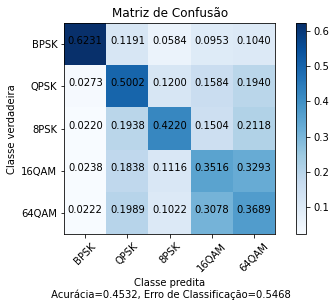

In [ ]:
# Definição da função para plotar a CM
def plot_confusion_matrix(cm, target_names, title='Confusion matrix'):
  """"
  Baseada na biblioteca ScikitLearn
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

  """

  accuracy = np.trace(cm) / float(np.sum(cm)) # acuracia
  misclass = 1 - accuracy                     # erro de classificacao

  cmap = plt.get_cmap('Blues') #Cor de fundo, no caso niveis azul

  # gera a figura da matriz de confusao
  plt.figure()
  im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  # gera as legendas com um angulo de 45 graus
  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

  # gera a escrita no interior dos quadrados
  for i in range(0, cm.shape[0]):
    for j in range(0, cm.shape[1]):
      plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="black")

  plt.tight_layout()
  plt.ylabel('Classe verdadeira')
  plt.xlabel('Classe predita\n Acurácia={:0.4f}, Erro de Classificação={:0.4f}'.format(accuracy, misclass))
  #plt.show()
# fim plot_confusion_matrix

# Matriz de Confusao de todo o dataset
X = test_data       # X sao os dados          
Y = test_lbls   # Y sao as labels
#y_pred = model.predict_classes(X_test, batch_size=batch_size)
y_pred = np.argmax(model.predict(X, batch_size=128), axis=1) #np.argmax pois model.predict_class vai ser removido do TF

classes =  ['BPSK', 'QPSK', '8PSK', '16QAM','64QAM']           # classes ou target_names
confmatrix = np.zeros([len(classes),len(classes)])      # Matriz de confusao
confmatrix_norm = np.zeros([len(classes),len(classes)]) # Matriz de confusao normalizada
for i in range(0,y_pred.shape[0]):
  j = list(Y[i,:]).index(1)
  k = y_pred[i]
  confmatrix[j,k] = confmatrix[j,k] + 1

for i in range(0,len(classes)):
  confmatrix_norm[i,:] = confmatrix[i,:] / np.sum(confmatrix[i,:])

plot_confusion_matrix(confmatrix_norm,classes,"Matriz de Confusão")

plt.savefig(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/{nTx}x{nRx}/allsnrs.png", dpi=120,  bbox_inches = "tight")

plt.show()

<Figure size 432x288 with 0 Axes>

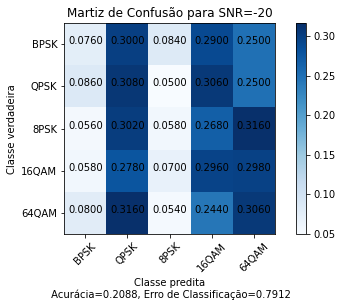

<Figure size 432x288 with 0 Axes>

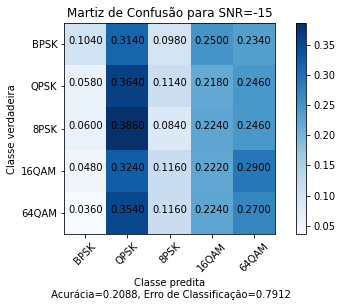

<Figure size 432x288 with 0 Axes>

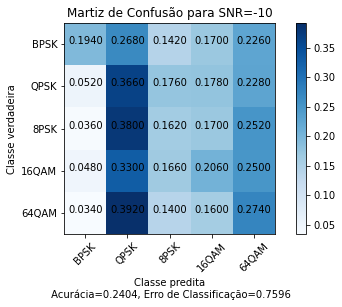

<Figure size 432x288 with 0 Axes>

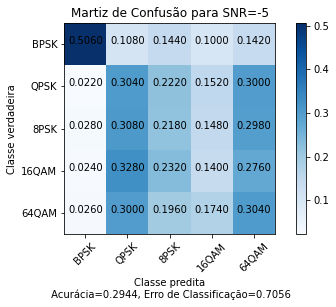

<Figure size 432x288 with 0 Axes>

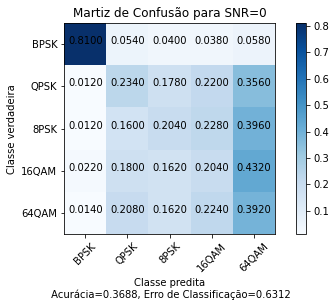

<Figure size 432x288 with 0 Axes>

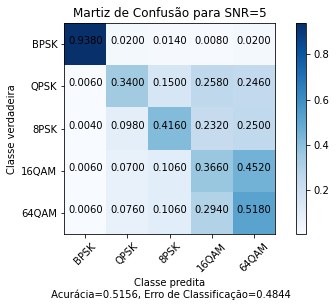

<Figure size 432x288 with 0 Axes>

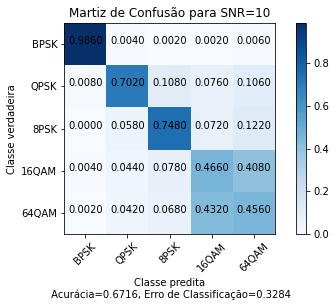

<Figure size 432x288 with 0 Axes>

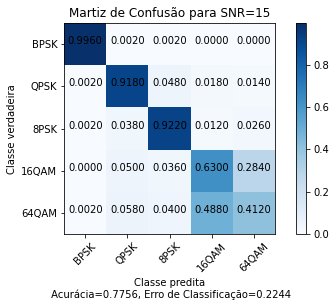

<Figure size 432x288 with 0 Axes>

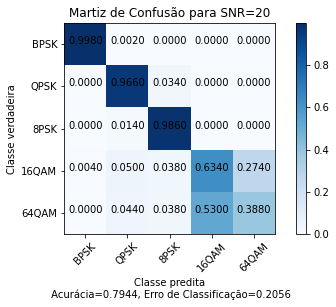

In [ ]:
acc = {}
idx = np.arange(0,len(X))
for snr in snrs:
    test_SNRs = list(map(lambda x: test_snrs[x], idx))
    test_X_i = X[(np.where(np.array(test_SNRs)==snr))]
    test_Y_i = Y[(np.where(np.array(test_SNRs)==snr))]    
 

    test_Y_i_hat = model.predict(test_X_i)
    classes = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM']
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    plt.figure()
    plot_confusion_matrix(confnorm, classes, title="Martiz de Confusão para SNR=%d"%(snr))
    plt.savefig(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/{nTx}x{nRx}/{snr}.png", dpi=120,  bbox_inches = "tight")
    
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
acc

{-20: 0.2088,
 -15: 0.2088,
 -10: 0.2404,
 -5: 0.2944,
 0: 0.3688,
 5: 0.5156,
 10: 0.6716,
 15: 0.7756,
 20: 0.7944}

In [ ]:
txt = open(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/{nTx}x{nRx}/acc_{nTx}_{nRx}.txt","w")
txt.write(str(acc))
txt.close()

# Tensorboard
### Ajustes dos hiper-parâmetros


In [ ]:
# %load_ext tensorboard

# import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
# import datetime

# !rm -rf ./logs/

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 64, 128]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.25, 0.5))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

# METRIC_ACCURACY = 'categorical_accuracy'

# with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
#   hp.hparams_config(
#     hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#   )

In [ ]:
# def train_test_model(hparams):
#   input = Input((2, 128, 1))                      
#   dr = hparams[HP_DROPOUT]                                                                      
#   x = Conv2D(hparams[HP_NUM_UNITS], (2, 3), padding='valid')(input) 
#   x = ReLU()(x)                                   
#   x = Dropout(dr)(x)

#   x = Conv2D(hparams[HP_NUM_UNITS]/4, (1, 3), padding='valid')(x)
#   x = ReLU()(x)
#   x = Dropout(dr)(x)

#   x = Flatten()(x)
#   x = Dense(128)(x)
#   x = ReLU()(x)
#   x = Dropout(dr)(x)


#   output = Dense(4, activation='softmax')(x)      #Camada de saida
#   model = Model(inputs=input, outputs=output)
#   tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#   model.compile(
#       optimizer=hparams[HP_OPTIMIZER],
#       loss='categorical_crossentropy',
#       metrics=['accuracy'],
#   )

#   model.fit(X_test, Y_test, epochs=20,callbacks=[tensorboard_callback])
#   _, accuracy = model.evaluate(X_val, Y_val)
#   return accuracy

In [ ]:
# def run(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)
#     accuracy = train_test_model(hparams)
#     tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
# session_num = 0

# for num_units in HP_NUM_UNITS.domain.values:
#   for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
#     for optimizer in HP_OPTIMIZER.domain.values:
#       hparams = {
#           HP_NUM_UNITS: num_units,
#           HP_DROPOUT: dropout_rate,
#           HP_OPTIMIZER: optimizer,
#       }
#       run_name = "run-%d" % session_num
#       print('--- Starting trial: %s' % run_name)
#       print({h.name: hparams[h] for h in hparams})
#       run('logs/hparam_tuning/' + run_name, hparams)
#       session_num += 1

In [ ]:
# %tensorboard --logdir /content/logs/fit/20210425-145605

In [ ]:
# model_json = model.to_json()
# with open("/content/drive/MyDrive/TCC_COLAB/Programas/MATLAB/Resultados/1x2/cnn2_128x16_d025.json", "w") as json_file:
#   json_file.write(model_json)
# model.save_weights("/content/drive/MyDrive/TCC_COLAB/Programas/MATLAB/Resultados/1x2/cnn2_128x16_d025.h5")

In [ ]:
# json_file = open('cnn2_2x2.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = keras.models.model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("cnn2_2x2.h5")

In [ ]:
# model.summary()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/1x2/acc_1_2.txt', 'r')
acc_1x2 = f.read()
f.close()

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/1x4/acc_1_4.txt', 'r')
acc_1x4 = f.read()
f.close()

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/2x2/acc_2_2.txt', 'r')
acc_2x2 = f.read()
f.close()

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/2x4/acc_2_4.txt', 'r')
acc_2x4 = f.read()
f.close()

f = open('/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/4x4/acc_4_4.txt', 'r')
acc_4x4 = f.read()
f.close()


In [ ]:
sys_1x2 = eval(acc_1x2)
sys_1x4 = eval(acc_1x4)
sys_2x2 = eval(acc_2x2)
sys_2x4 = eval(acc_2x4)
sys_4x4 = eval(acc_4x4)

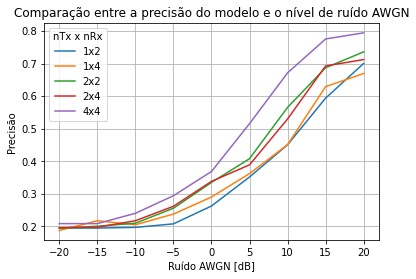

In [ ]:
plt.plot(list(sys_1x2.keys()),list(sys_1x2.values()), label='1x2')
plt.plot(list(sys_1x4.keys()),list(sys_1x4.values()), label='1x4')
plt.plot(list(sys_2x2.keys()),list(sys_2x2.values()), label='2x2')
plt.plot(list(sys_2x4.keys()),list(sys_2x4.values()), label='2x4')
plt.plot(list(sys_4x4.keys()),list(sys_4x4.values()), label='4x4')

plt.title('Comparação entre a precisão do modelo e o nível de ruído AWGN')
plt.ylabel('Precisão')
plt.xlabel('Ruído AWGN [dB]')
plt.grid()
plt.legend(title='nTx x nRx')

plt.savefig(f"/content/drive/MyDrive/TCC_COLAB/Resultados/MIMO/graph.png", dpi=120,  bbox_inches = "tight")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
b = np.random.randint(1,3,[128])-1
b

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1])

In [ ]:
int(b.size/np.log2(4))

64

In [ ]:
d_bpsk = np.zeros([128], dtype='complex')
d_qpsk = np.zeros([64], dtype='complex')
d_16qam = np.zeros([32], dtype='complex')
d_64qam = np.zeros([21], dtype='complex')

for i in range(b.size):
  d_bpsk[i] = (1 - 2*b[i]) + 1j*(1 - 2*b[i])

for i in range(int(b.size/np.log2(4))):
  d_qpsk[i] = (1 - 2*b[2*i]) + 1j*(1 - 2*b[2*i+1])

for i in range(int(b.size/np.log2(16))):
  d_16qam[i] = (1 - 2*b[4*i])*(2 - (1 - 2*b[4*i+2])) + 1j*(1 - 2*b[4*i+1])*(2 - (1 - 2*b[4*i+3]))

for i in range(int(b.size/np.log2(64))):
  d_64qam[i] = (1 - 2*b[6*i])*(4 - (1 - 2*b[6*i+2])*(2 - (1 - 2*b[6*i+4]))) + 1j*(1 - 2*b[6*i+1])*(4 - (1 - 2*b[6*i+3])*(2 - (1 - 2*b[6*i+5])))

d_bpsk = (1/np.sqrt(2))*d_bpsk 
d_qpsk = (1/np.sqrt(2))*d_qpsk 
d_16qam =(1/np.sqrt(10))*d_16qam 
d_64qam =(1/np.sqrt(42))*d_64qam 


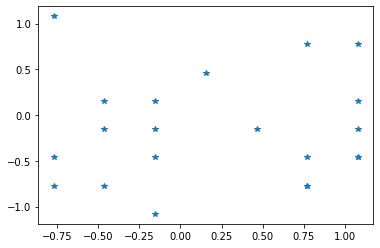

In [ ]:
plt.plot(d_64qam.real, d_64qam.imag, '*')